In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from numpy.linalg import inv, norm
from mpl_toolkits import mplot3d
from scipy.stats import multivariate_normal
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn import neighbors, datasets
import os
import math
import pickle
from sklearn.linear_model import Perceptron
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC
from scipy.special import softmax, expit

from sklearn.metrics import classification_report, confusion_matrix , accuracy_score, log_loss
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from numpy.random import seed
from tensorflow.random import set_seed

# few global variables
ind = [1,2,3,9]
cmap_bold = [sns.color_palette('bright')[i] for i in ind]
cmap_light = [sns.color_palette('dark')[i] for i in ind]

# Dataset 1A

In [2]:
#reading the training data and storing the features and outputs in corresponding variables
df_train= pd.read_csv("train.csv",header=None)
df_train.rename(columns={0:"x1", 1:"x2", 2:"y"}, inplace=True)
df_train['y']=df_train['y'].astype('int32')
x_train = np.array(df_train[['x1','x2']]) ; y_train = np.array(df_train[['y']]) ; y_train = y_train.reshape((y_train.shape[0],))

#reading the test data and storing the features and outputs in corresponding variables
df_test= pd.read_csv("dev.csv",header=None)
df_test.rename(columns={0:"x1", 1:"x2", 2:"y"}, inplace=True)
df_dev = df_test
df_test['y']=df_test['y'].astype('int32')
test_data = np.array(df_test[['x1','x2','y']])
N_dev = test_data.shape[0]
np.random.shuffle(test_data)
x_test = test_data[:N_dev//2, [0,1]]; y_test = test_data[:N_dev//2,2] ; y_test.reshape((y_test.shape[0],))
x1_test = x_test[:,0]; x2_test = x_test[:,1];
val_data = test_data[N_dev//2:,:]
x_va = test_data[N_dev//2:, [0,1]]; y_va = test_data[N_dev//2:,2] ; y_va = y_va.reshape((y_va.shape[0],))
x1_va = x_va[:,0]; x2_va = x_va[:,1];

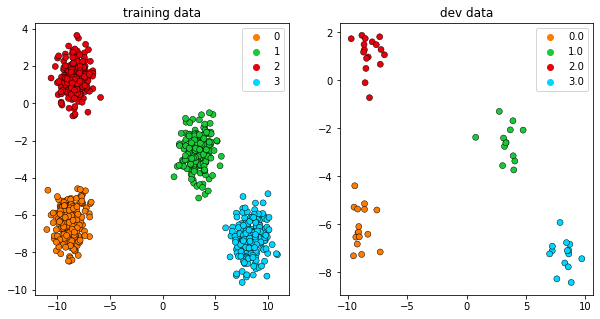

In [3]:
# visualising the data
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('training data')
sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train.reshape((y_train.shape[0])),palette=cmap_bold,alpha=1.0,edgecolor='black')
plt.subplot(1,2,2)
plt.title('dev data')
sns.scatterplot(x=x_test[:,0],y=x_test[:,1],hue=y_test.reshape((y_test.shape[0])),palette=cmap_bold,alpha=1.0,edgecolor='black')
plt.show()

## perceptron model (ovo)

In [4]:
# Hyperparameter tuning
lrs = [1,1e-1,1e-2,1e-3,1e-4]
acc_and_iter = []
for (i,lr) in enumerate(lrs):
    model = Perceptron(eta0=lr,n_iter_no_change=2,tol=1e-4,verbose=0,early_stopping=True)
    # model.fit(x_train,y_train,intercept_init=[10,10,10,10])  # this uses ovr approach
    p_ovo = OneVsOneClassifier(model)
    p_ovo.fit(x_train,y_train)


    # the change of eta0 has no change on the number of epochs required for convergence
    # n_iter_no_change was changed to 2 from 5 (because this dataset is very easily linearly classifiable)
    # because it is a classification and data is easily classifiable by a linear classifier tol = 1e-3 and tol = 1e-4 -
    # take same number of epochs to converge

    yhat_tr = p_ovo.predict(x_train)
    print(f"The confusion matrix of model with lr = {lr} for training data:",confusion_matrix(y_train,yhat_tr),sep='\n')

    yhat_va = p_ovo.predict(x_va) 
    print(f"The confusion matrix of model with lr = {lr} for validation data :",confusion_matrix(y_va,yhat_va),sep='\n')
    
    acc_tr = accuracy_score(y_train,yhat_tr) 
    acc_va = accuracy_score(y_va,yhat_va)
    max_iter = max([p_ovo.estimators_[a].n_iter_ for a in range(6)])
    acc_and_iter.append((acc_tr*100,acc_va*100,max_iter))
    
print('*********************************\n\n','training acc , validation acc and n_iter for different learning rates:\n')
print(acc_and_iter)

The confusion matrix of model with lr = 1 for training data:
[[200   0   0   0]
 [  0 200   0   0]
 [  0   0 200   0]
 [  0   0   0 200]]
The confusion matrix of model with lr = 1 for validation data :
[[14  0  0  0]
 [ 0 17  0  0]
 [ 0  0 13  0]
 [ 0  0  0 16]]
The confusion matrix of model with lr = 0.1 for training data:
[[200   0   0   0]
 [  0 200   0   0]
 [  0   0 200   0]
 [  0   0   0 200]]
The confusion matrix of model with lr = 0.1 for validation data :
[[14  0  0  0]
 [ 0 17  0  0]
 [ 0  0 13  0]
 [ 0  0  0 16]]
The confusion matrix of model with lr = 0.01 for training data:
[[200   0   0   0]
 [  0 200   0   0]
 [  0   0 200   0]
 [  0   0   0 200]]
The confusion matrix of model with lr = 0.01 for validation data :
[[14  0  0  0]
 [ 0 17  0  0]
 [ 0  0 13  0]
 [ 0  0  0 16]]
The confusion matrix of model with lr = 0.001 for training data:
[[200   0   0   0]
 [  0 200   0   0]
 [  0   0 200   0]
 [  0   0   0 200]]
The confusion matrix of model with lr = 0.001 for validatio

Because all the models gave same accuracy within same number of epochs,   
we will use lr = 1 as it is the maximum learning rate (which is the conventional value for learning rate).  
  
  
The loss(training and validation) for all values of hyperparameters is 0.

In [5]:
# Accuracy of best model on test data.
# best model is lr =1.
model = Perceptron(eta0=1,n_iter_no_change=5,tol=1e-4,verbose=0,early_stopping=True)
p_ovo = OneVsOneClassifier(model)
p_ovo.fit(x_train,y_train)

yhat_te = p_ovo.predict(x_test)
print(f"The confusion matrix of model with lr = {lr} for training data:",confusion_matrix(y_test,yhat_te),sep='\n')
acc = accuracy_score(y_test,yhat_te)
print('Classification Accuracy of best model on test data:',f'{acc*100}%')

The confusion matrix of model with lr = 0.0001 for training data:
[[16  0  0  0]
 [ 0 13  0  0]
 [ 0  0 17  0]
 [ 0  0  0 14]]
Classification Accuracy of best model on test data: 100.0%


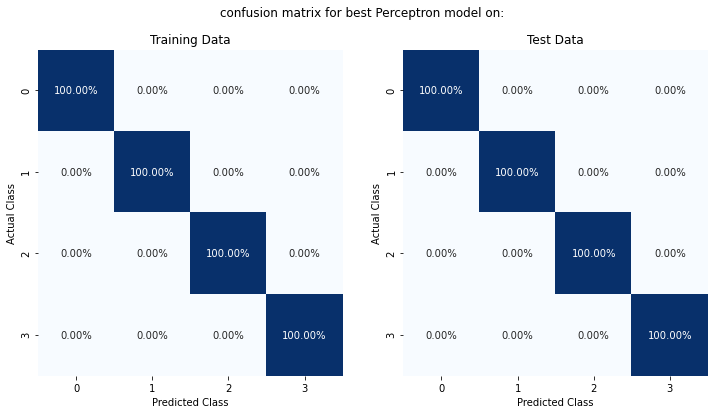

In [6]:
# Confusion matrix of best model on training and test data
yhat_tr = p_ovo.predict(x_train) 
yhat_te = p_ovo.predict(x_test)

fig = plt.figure(figsize=(12,6))
plt.suptitle('confusion matrix for best Perceptron model on:')
plt.subplot(1,2,1)
plt.title('Training Data')
cf = confusion_matrix(y_train,yhat_tr,normalize='true')
sns.heatmap(cf,annot=True,fmt='.2%',cmap='Blues',cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

plt.subplot(1,2,2)
plt.title('Test Data')
cf = confusion_matrix(y_test,yhat_te,normalize='true')
sns.heatmap(cf,annot=True,fmt='.2%',cmap='Blues',cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

plt.show()

[]

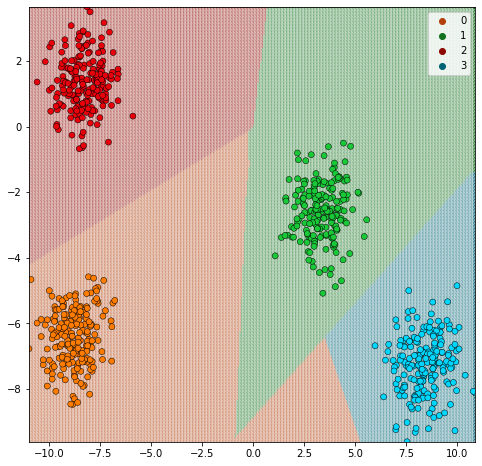

In [7]:
# Decision Regions of the best model
fig = plt.figure(figsize=(8,8))
xlim =  [np.amin(x_train[:,0]),np.amax(x_train[:,0])]
ylim = [np.amin(x_train[:,1]),np.amax(x_train[:,1])]
plt.xlim(xlim)
plt.ylim(ylim)
# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 300)
yy = np.linspace(ylim[0], ylim[1], 300)
YY, XX = np.meshgrid(yy, xx)
xy = np.c_[XX.ravel(), YY.ravel()]
# print(xx.shape ,xy.shape,sep = '\n')
Z = p_ovo.predict(xy)
# plot decision boundary and margins
palette_bold = cmap_bold
palette_light = cmap_light
sns.scatterplot(x = XX.ravel(),y = YY.ravel(), hue = Z,palette=palette_light,legend= True)
sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train,palette=palette_bold,alpha=1.0,edgecolor="black",legend=False)
plt.plot()

## MLFFNN

In [8]:
# utilities
def build_mlfnn(hidden_neurons,num_layers=1,num_classes=4): #hidden neurons is a list of number of hidden units in each hidden layer
    model=tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(2)))
    model.add(tf.keras.layers.Dense(hidden_neurons[0],activation='sigmoid'))
    if num_layers==2:
        model.add(tf.keras.layers.Dense(hidden_neurons[1],activation='sigmoid'))

    model.add(tf.keras.layers.Dense(num_classes,activation='softmax'))
    return model

def train_model(model,epochs,X_train,Y_train,X_valid,Y_valid,verbose = 0):
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,optimizer=keras.optimizers.SGD(lr=1),metrics=['accuracy'])
    history=model.fit(X_train,Y_train,epochs=epochs,batch_size=32,validation_data=(X_valid,Y_valid),verbose=verbose)
    return history

def plot_nn_decision_regions (x_train,y_train,model,palette_bold,palette_light):
    # sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train,palette=palette_bold,alpha=1.0,edgecolor="black",legend=False)

    xlim =  [np.amin(x_train[:,0]),np.amax(x_train[:,0])]
    ylim = [np.amin(x_train[:,1]),np.amax(x_train[:,1])]

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 300)
    yy = np.linspace(ylim[0], ylim[1], 300)
    plt.xlim(xlim) ; plt.ylim(ylim)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.c_[XX.ravel(), YY.ravel()]
    # print(xx.shape ,xy.shape,sep = '\n')
    Z = np.argmax(model.predict(xy),axis=1)
    n = np.unique(Z).shape[0]
    # plot decision boundary and margins
    sns.scatterplot(x = XX.ravel(),y = YY.ravel(), hue = Z.ravel(),palette=palette_light[:n],legend= True)
    sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train,palette=palette_bold,alpha=1.0,edgecolor="black",legend=False)


In [19]:
# tables of classification accuracies for different values of hyperparameters
epochs = 30
list_h_neurons = [[2,2],[3,3],[4,4],[5,5],[6,6],[7,7],[6],[7],[8],[9],[10],[11],[12],[13]]
accs_and_loss = [] # store tuples of (h_neurons,tr_acc,tr_loss,va_acc,va_loss)
for h_neurons in list_h_neurons:
    model = build_mlfnn(hidden_neurons=h_neurons,num_layers=len(h_neurons),num_classes=4)
    train_model(model,epochs,x_train,y_train,x_va,y_va)
    print('\n *************************************************** \n')
    yhat_tr = model.predict(x_train) ; yhat_tr = np.argmax(yhat_tr,axis=1)
    yhat_va = model.predict(x_va)    ; yhat_va = np.argmax(yhat_va,axis=1)
#     yhat_te = model.predict(x_test)    ; yhat_te = np.argmax(yhat_te,axis=1) 
    
    tr_loss,tr_acc  = model.evaluate(x_train,y_train)
    va_loss,va_acc  = model.evaluate(x_va,y_va)
    accs_and_loss.append((h_neurons,round(tr_acc,3),round(tr_loss,3),round(va_acc,3),round(va_loss,3)))
for i in range(len(list_h_neurons)):
    print(accs_and_loss[i]) 


 *************************************************** 

2/2 [==============================] - 0s 998us/step - loss: 0.3943 - accuracy: 0.7333

 *************************************************** 

2/2 [==============================] - 0s 1000us/step - loss: 0.6956 - accuracy: 0.5000

 *************************************************** 

2/2 [==============================] - 0s 997us/step - loss: 0.3875 - accuracy: 0.7333

 *************************************************** 

2/2 [==============================] - 0s 1000us/step - loss: 0.3831 - accuracy: 0.7333

 *************************************************** 

2/2 [==============================] - 0s 999us/step - loss: 0.0223 - accuracy: 1.0000

 *************************************************** 

2/2 [==============================] - 0s 997us/step - loss: 0.0325 - accuracy: 1.0000

 *************************************************** 

2/2 [==============================] - 0s 998us/step - loss: 0.0102 - accuracy: 1.00

Clearly among the models with 1 hidden layer , model with 8 hidden neurons is the least complex model and has the highest accuracy.  
And among the models with 2 hidden layers, model with 6 hidden neurons in both hidden layers is the least complex model with highest accuracy. And among these two model with single hidden layer has less number of parameters - 60 compared to 88 in other case. So, we go with model with single hidden layer.


In [20]:
# classification accuracy of best model on test data
epochs = 30
model = build_mlfnn(hidden_neurons=[8],num_layers=1,num_classes=4)
train_model(model,epochs,x_train,y_train,x_va,y_va)

te_loss,te_acc = model.evaluate(x_test,y_test)
print(round(te_loss,3),te_acc*100)

2/2 [==============================] - 0s 1000us/step - loss: 0.0158 - accuracy: 1.0000
0.016 100.0


2/2 [==============================] - 0s 517us/step - loss: 0.0066 - accuracy: 1.0000


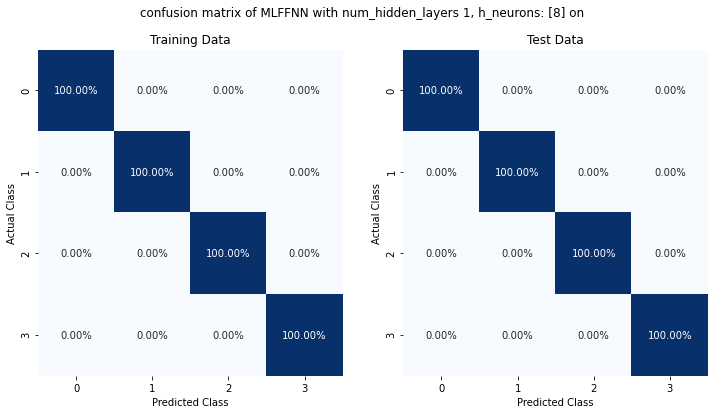

In [21]:
#confusion matrix for best model on Training and Test Data
h_neurons = [8]
epochs = 30
model = build_mlfnn(hidden_neurons=h_neurons,num_layers=len(h_neurons),num_classes=4)
train_model(model,epochs,x_train,y_train,x_va,y_va)

yhat_tr = model.predict(x_train) ; yhat_tr = np.argmax(yhat_tr,axis=1)
yhat_te = model.predict(x_test)  ; yhat_te = np.argmax(yhat_te,axis=1)
model.evaluate(x_train,y_train) ; model.evaluate(x_va,y_va)

fig = plt.figure(figsize=(12,6))
plt.suptitle(f'confusion matrix of MLFFNN with num_hidden_layers {len(h_neurons)}, h_neurons: {h_neurons} on')
for i in range(2):
    plt.subplot(1,2,i+1)
    cf = confusion_matrix(y_train,yhat_tr,normalize='true')if i==0 else confusion_matrix(y_test,yhat_te,normalize='true')
    sns.heatmap(cf,annot=True,fmt='.2%',cmap='Blues',cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Training Data' if i==0 else 'Test Data') 
plt.show()


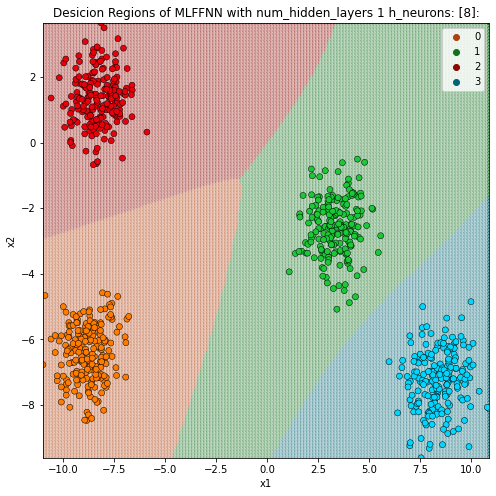

In [22]:
#plot of decision regions using the same model from above cell
fig = plt.figure(figsize=(8,8))
plt.title(f'Desicion Regions of MLFFNN with num_hidden_layers {len(h_neurons)} h_neurons: {h_neurons}:')
plt.xlabel('x1') ; plt.ylabel('x2')
palette_bold = cmap_bold ; palette_light = cmap_light
plot_nn_decision_regions (x_train,y_train,model,palette_bold,palette_light)
plt.show()

## Linear SVM (ovo)

In [13]:
# utilities
def svm_decision_regions (x_train,y_train,classifier,palette_bold,palette_light): #plot training samples along with decision regions

    ax = plt.gca()
    xlim =  [np.amin(x_train[:,0]),np.amax(x_train[:,0])]
    ylim = [np.amin(x_train[:,1]),np.amax(x_train[:,1])]
    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 300)
    yy = np.linspace(ylim[0], ylim[1], 300)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    # print(xx.shape ,xy.shape,sep = '\n')
    Z = classifier.decision_function(xy).reshape(XX.shape)
    z = Z.copy().ravel() ; z[np.where(z<=0)] = 0 ; z[np.where(z>0)] = 1
    # plot the colored decision regions
    sns.scatterplot(x = XX.ravel(),y = YY.ravel(), hue = z,palette=palette_light,legend= True)
    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['-.', '-', '--'])

    sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train,palette=palette_bold,alpha=1.0,edgecolor="black",legend=False)
    # plot support vectors
    ax.scatter(classifier.support_vectors_[:, 0], classifier.support_vectors_[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')
    return Z


In [14]:
pairs = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]

#creating a ovo classifier
classifier = SVC(kernel = 'linear')
linear_ovo = OneVsOneClassifier(classifier)

linear_ovo.fit(x_train,y_train)
yhat_va = linear_ovo.predict(x_va)
yhat_tr = linear_ovo.predict(x_train)

#there are no hyperparameters to modify as this is a linearly separable data and linear kernel is the only hyperparameter
# training and validation accuracy for this model:
acc_tr,acc_va = accuracy_score(y_train,yhat_tr) , accuracy_score(y_va,yhat_va)
print('For the SVM with linear kernel on Dataset 1A:')
print(f'Training Accuracy: {acc_tr*100}% , Validation Accuracy: {acc_va*100}%')

For the SVM with linear kernel on Dataset 1A:
Training Accuracy: 100.0% , Validation Accuracy: 100.0%


In [15]:
# Classification accuracy of model on test data:
yhat_te = linear_ovo.predict(x_test)
acc_te = accuracy_score(y_test,yhat_te)
print('For the SVM with linear kernel on Dataset 1A:')
print(f'Test Accuracy : {acc_te*100}%')

For the SVM with linear kernel on Dataset 1A:
Test Accuracy : 100.0%


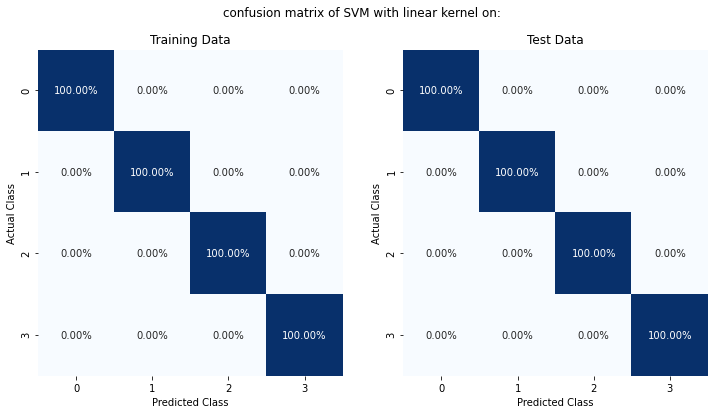

In [16]:
# Confusion Matrix fir best model on Training and Test Data
# using the same model as above cell
fig = plt.figure(figsize=(12,6))
plt.suptitle('confusion matrix of SVM with linear kernel on:')
for i in range(2):
    plt.subplot(1,2,i+1)
    cf = confusion_matrix(y_train,yhat_tr,normalize='true')if i==0 else confusion_matrix(y_test,yhat_te,normalize='true')
    sns.heatmap(cf,annot=True,fmt='.2%',cmap='Blues',cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Training Data' if i==0 else 'Test Data') 
plt.show()

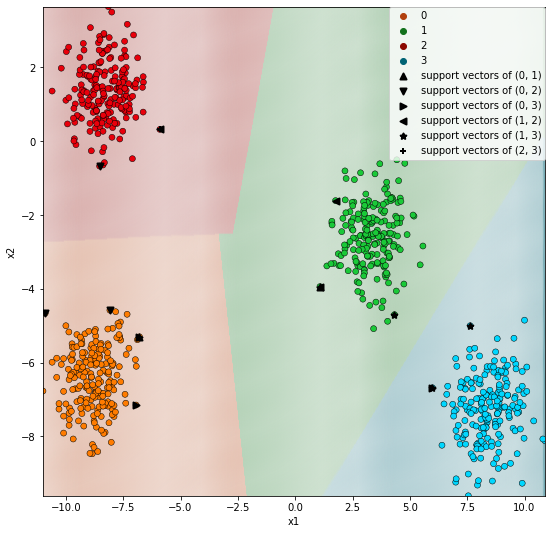

In [17]:
# Plot of Decison Regions and support vectors of best model
palette_light = cmap_light
palette_bold = cmap_bold

fig = plt.figure(figsize=(9,9))
ax = plt.gca()
xlim =  [np.amin(x_train[:,0]),np.amax(x_train[:,0])]
ylim = [np.amin(x_train[:,1]),np.amax(x_train[:,1])]
plt.xlim(xlim) ; plt.ylim(ylim)
plt.xlabel('x1') ; plt.ylabel('x2')
# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 500)
yy = np.linspace(ylim[0], ylim[1], 500)
YY, XX = np.meshgrid(yy, xx)
xy = np.c_[XX.ravel(), YY.ravel()]
Z = linear_ovo.predict(xy)
sns.scatterplot(x = XX.ravel(),y = YY.ravel(), hue = Z,palette=palette_light,legend= True)
sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train.reshape((y_train.shape[0],)),palette=palette_bold,
                alpha=1.0,edgecolor="black",legend=False)
markers = ['^','v','>','<','*','+']
for (i,pair) in enumerate(pairs):
    plt.scatter(linear_ovo.estimators_[i].support_vectors_[:, 0], linear_ovo.estimators_[i].support_vectors_[:, 1]
              ,marker=markers[i],color='k',linewidth=2,label=f'support vectors of {pair}')
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)
plt.show()

Confusion Matrix for (0, 1) on Training data: 
[[200   0]
 [  0 200]]
Classification_report for (0, 1) on Training data:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       200
         1.0       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

Confusion Matrix for (0, 1) on Test Data:
[[16  0]
 [ 0 13]]
Classification_report for (0, 1) on Test Data:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16
         1.0       1.00      1.00      1.00        13

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29

Confusion Matrix for (0, 2) on Training data: 
[[200   0]
 [  0 200]]
Classification_report for (0, 2) on Training da

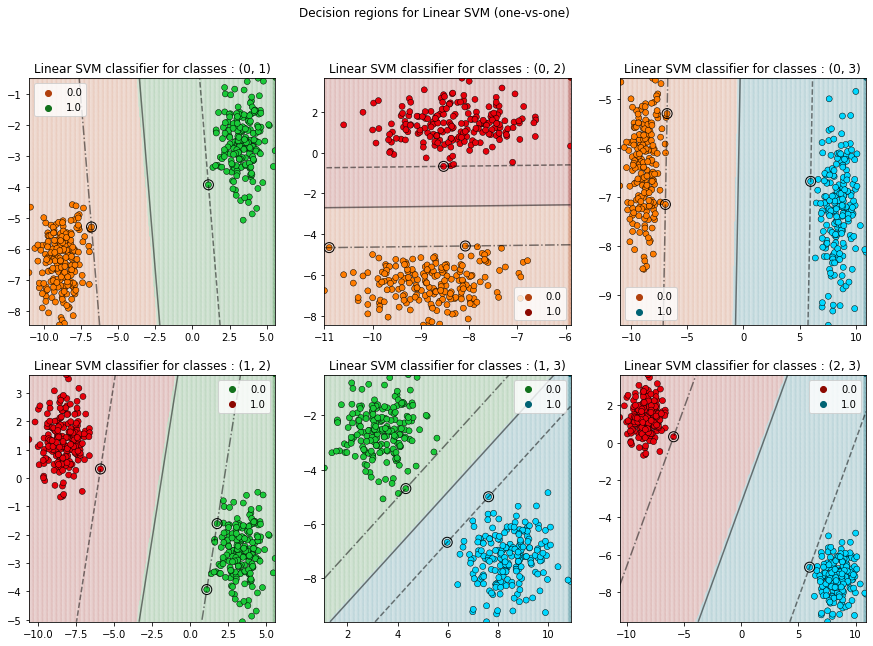

In [18]:
# Decision regions and accuarcies pair wise
linear_classifier = SVC(kernel = 'linear')

x_class_tr = {} ; y_class_tr = {}  # list for storing the training points of each class separately
x_class_te = {} ; y_class_te = {}  # list for storing the test points of each class separately
for i in range(4):
    x_class_tr[i] = x_train[np.where(y_train==i)[0],:]
    len_tr = x_class_tr[i].shape[0]
    y_class_tr[i] = np.ones(len_tr)*i

    x_class_te[i]=x_test[np.where(y_test==i)[0],:]
    len_te = x_class_te[i].shape[0]
    y_class_te[i] = np.ones(len_te)*i

pairs = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
fig = plt.figure(figsize=(15,10))
plt.suptitle('Decision regions for Linear SVM (one-vs-one)')
for (count,pair) in enumerate(pairs):
    (i,j) = pair
    x_train_pair = np.append(x_class_tr[i],x_class_tr[j],axis=0)
    y_train_pair = np.append(y_class_tr[i],y_class_tr[j],axis=0)
    linear_classifier.fit(x_train_pair,y_train_pair)

    x_test_pair = np.append(x_class_te[i],x_class_te[j],axis=0)
    y_test_pair = np.append(y_class_te[i],y_class_te[j],axis=0)
    y_predict = linear_classifier.predict(x_test_pair)
    y_train_predict = linear_classifier.predict(x_train_pair)
    print(f'Confusion Matrix for {pair} on Training data: ', confusion_matrix(y_train_pair,y_train_predict),sep='\n')
    print(f'Classification_report for {pair} on Training data:', classification_report(y_train_pair,y_train_predict),sep='\n')
    print(f'Confusion Matrix for {pair} on Test Data:', confusion_matrix(y_test_pair,y_predict),sep='\n')
    print(f'Classification_report for {pair} on Test Data:', classification_report(y_test_pair,y_predict),sep='\n')

    palette_bold = [cmap_bold[a] for a in pair]
    palette_light = [cmap_light[a] for a in pair]
    plt.subplot(2,3,count+1)
    Z = svm_decision_regions(x_train_pair,y_train_pair,linear_classifier,palette_bold,palette_light)
    plt.title(label=f'Linear SVM classifier for classes : {pair}' )

plt.show()


# Dataset 1B

In [23]:
#reading the training data and storing the features and outputs in corresponding variables
df_train= pd.read_csv("G:\\ubuntu2-windows2\\Sem6\\PRML - CS5691\\Assignments_2021\\Assignment2/Dataset_1B/train.csv",header=None)
df_train.rename(columns={0:"x1", 1:"x2", 2:"y"}, inplace=True)
df_train['y']=df_train['y'].astype('int32')
x_train = np.array(df_train[['x1','x2']]) ; y_train = np.array(df_train[['y']]) ; y_train = y_train.reshape((y_train.shape[0],))

#reading the test data and storing the features and outputs in corresponding variables
df_test= pd.read_csv("G:\\ubuntu2-windows2\\Sem6\\PRML - CS5691\\Assignments_2021\\Assignment2/Dataset_1B/dev.csv",header=None)
df_test.rename(columns={0:"x1", 1:"x2", 2:"y"}, inplace=True)
df_dev = df_test
df_test['y']=df_test['y'].astype('int32')
test_data = np.array(df_test[['x1','x2','y']])
N_dev = test_data.shape[0]
np.random.shuffle(test_data)
x_test = test_data[:N_dev//2, [0,1]]; y_test = test_data[:N_dev//2,2] ; y_test.reshape((y_test.shape[0],))
x1_test = x_test[:,0]; x2_test = x_test[:,1];
val_data = test_data[N_dev//2:,:]
x_va = test_data[N_dev//2:, [0,1]]; y_va = test_data[N_dev//2:,2] ; y_va = y_va.reshape((y_va.shape[0],))
x1_va = x_va[:,0]; x2_va = x_va[:,1];

## MLFFNN

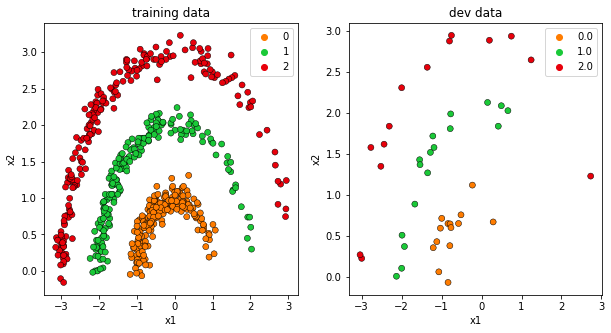

In [24]:
# visualising the data
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('training data')
sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train.reshape((y_train.shape[0])),palette=cmap_bold[:3],alpha=1.0,edgecolor='black')
plt.xlabel('x1') ; plt.ylabel('x2')
plt.subplot(1,2,2)
plt.title('dev data')
sns.scatterplot(x=x_test[:,0],y=x_test[:,1],hue=y_test.reshape((y_test.shape[0])),palette=cmap_bold[:3],alpha=1.0,edgecolor='black')
plt.xlabel('x1') ; plt.ylabel('x2')
plt.show()

In [25]:
# utilities
def build_mlfnn(hidden_neurons,num_layers=1,num_classes=4): #hidden neurons is a list of number of hidden units in each hidden layer
    model=tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(2)))
    model.add(tf.keras.layers.Dense(hidden_neurons[0],activation='sigmoid'))
    if num_layers==2:
        model.add(tf.keras.layers.Dense(hidden_neurons[1],activation='sigmoid'))

    model.add(tf.keras.layers.Dense(num_classes,activation='softmax'))
    return model

def train_model(model,epochs,X_train,Y_train,X_valid,Y_valid,verbose = 0):
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,optimizer=keras.optimizers.SGD(lr=1),metrics=['accuracy'])
    history=model.fit(X_train,Y_train,epochs=epochs,batch_size=32,validation_data=(X_valid,Y_valid),verbose=verbose)
    return history

def plot_nn_decision_regions (x_train,y_train,model,palette_bold,palette_light):
    # sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train,palette=palette_bold,alpha=1.0,edgecolor="black",legend=False)

    xlim =  [np.amin(x_train[:,0]),np.amax(x_train[:,0])]
    ylim = [np.amin(x_train[:,1]),np.amax(x_train[:,1])]

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 300)
    yy = np.linspace(ylim[0], ylim[1], 300)
    plt.xlim(xlim) ; plt.ylim(ylim)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.c_[XX.ravel(), YY.ravel()]
    # print(xx.shape ,xy.shape,sep = '\n')
    Z = np.argmax(model.predict(xy),axis=1)
    n = np.unique(Z).shape[0]
    # plot decision boundary and margins
    sns.scatterplot(x = XX.ravel(),y = YY.ravel(), hue = Z.ravel(),palette=palette_light[:n],legend= True)
    sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train,palette=palette_bold,alpha=1.0,edgecolor="black",legend=False)


In [26]:
# tables of classification accuracies for different values of hyperparameters
epochs = 30
seed(0)
set_seed(0)
list_h_neurons = [[2,2],[3,3],[4,4],[5,5],[6,6],[7,7],[8,8],[9,9],[10,10],[6],[7],[8],[9],[10],[11],[12],[13],[14],[15],[16],[17],[18]]
accs_and_loss = [] # store tuples of (h_neurons,tr_acc,tr_loss,va_acc,va_loss)
for h_neurons in list_h_neurons:
    model = build_mlfnn(hidden_neurons=h_neurons,num_layers=len(h_neurons),num_classes=3)
    train_model(model,epochs,x_train,y_train,x_va,y_va)
    print('\n *************************************************** \n')
    yhat_tr = model.predict(x_train) ; yhat_tr = np.argmax(yhat_tr,axis=1)
    yhat_va = model.predict(x_va)    ; yhat_va = np.argmax(yhat_va,axis=1)
#     yhat_te = model.predict(x_test)    ; yhat_te = np.argmax(yhat_te,axis=1) 
    
    tr_loss,tr_acc  = model.evaluate(x_train,y_train)
    va_loss,va_acc  = model.evaluate(x_va,y_va)
    accs_and_loss.append((h_neurons,round(tr_acc,3),round(tr_loss,3),round(va_acc,3),round(va_loss,3)))

print('hidden layers , training accuracy, training loss , validation accuracy, validation loss:')
for i in range(len(list_h_neurons)):
    print(accs_and_loss[i]) 


 *************************************************** 

2/2 [==============================] - 0s 998us/step - loss: 0.1005 - accuracy: 1.0000

 *************************************************** 

2/2 [==============================] - 0s 500us/step - loss: 0.1183 - accuracy: 1.0000

 *************************************************** 

2/2 [==============================] - 0s 998us/step - loss: 0.0345 - accuracy: 1.0000

 *************************************************** 

2/2 [==============================] - 0s 997us/step - loss: 0.0415 - accuracy: 1.0000

 *************************************************** 

2/2 [==============================] - 0s 515us/step - loss: 0.0376 - accuracy: 1.0000

 *************************************************** 

2/2 [==============================] - 0s 502us/step - loss: 0.2439 - accuracy: 0.9333

 *************************************************** 

2/2 [==============================] - 0s 1ms/step - loss: 0.0545 - accuracy: 1.0000



clearly, all the single hidden layer models have high validation loss than double hidden layer model with 5 hidden layers each.  
And also this model is less complex than other high validation accuracy and low validation loss models with single hidden layer.  
So, we choose this as the best model.

In [27]:
# classification accuracy of best model on test data
seed(0)
set_seed(0)
epochs = 30
model = build_mlfnn(hidden_neurons=[5,5],num_layers=2,num_classes=3)
train_model(model,epochs,x_train,y_train,x_va,y_va)

te_loss,te_acc = model.evaluate(x_test,y_test)
print(round(te_loss,3),te_acc*100)

2/2 [==============================] - 0s 997us/step - loss: 0.0363 - accuracy: 1.0000
0.036 100.0


2/2 [==============================] - 0s 511us/step - loss: 0.0377 - accuracy: 1.0000


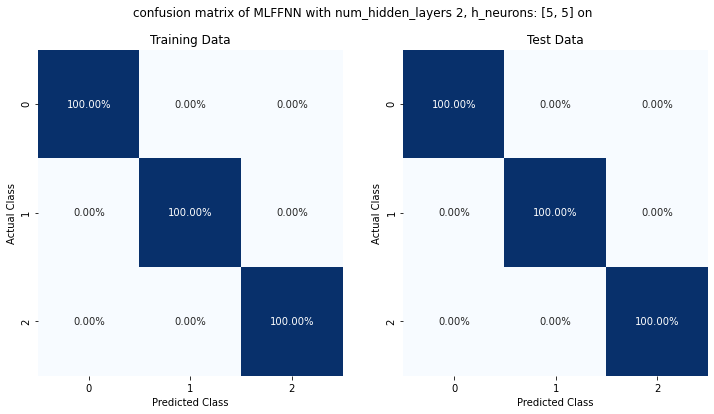

In [28]:
#confusion matrix for best model on Training and Test Data
seed(0)
set_seed(0)
h_neurons = [5,5]
epochs = 30
model = build_mlfnn(hidden_neurons=h_neurons,num_layers=len(h_neurons),num_classes=3)
train_model(model,epochs,x_train,y_train,x_va,y_va)

yhat_tr = model.predict(x_train) ; yhat_tr = np.argmax(yhat_tr,axis=1)
yhat_te = model.predict(x_test)  ; yhat_te = np.argmax(yhat_te,axis=1)
model.evaluate(x_train,y_train) ; model.evaluate(x_va,y_va)

fig = plt.figure(figsize=(12,6))
plt.suptitle(f'confusion matrix of MLFFNN with num_hidden_layers {len(h_neurons)}, h_neurons: {h_neurons} on')
for i in range(2):
    plt.subplot(1,2,i+1)
    cf = confusion_matrix(y_train,yhat_tr,normalize='true')if i==0 else confusion_matrix(y_test,yhat_te,normalize='true')
    sns.heatmap(cf,annot=True,fmt='.2%',cmap='Blues',cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Training Data' if i==0 else 'Test Data') 
plt.show()


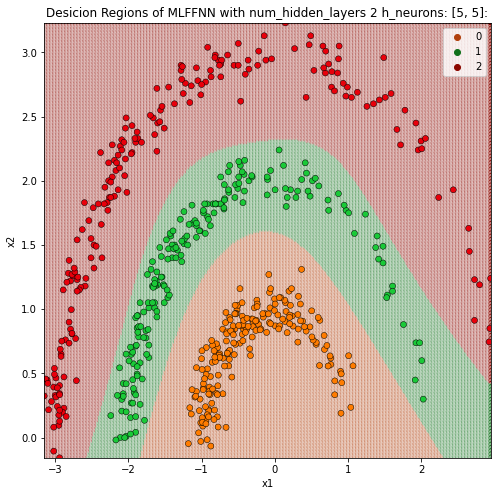

In [29]:
#plot of decision regions using the same model from above cell
fig = plt.figure(figsize=(8,8))
plt.title(f'Desicion Regions of MLFFNN with num_hidden_layers {len(h_neurons)} h_neurons: {h_neurons}:')
plt.xlabel('x1') ; plt.ylabel('x2')
palette_bold = cmap_bold[:3] ; palette_light = cmap_light[:3]
plot_nn_decision_regions (x_train,y_train,model,palette_bold,palette_light)
plt.show()

In [30]:
# utilities for plotting the evolution of outputs of different nodes
def build_mlfnn(hidden_neurons,num_layers=1,num_classes=4): #hidden neurons is a list of number of hidden units in each hidden layer
    model=tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(2)))
    model.add(tf.keras.layers.Dense(hidden_neurons[0],activation='sigmoid'))
    if num_layers==2:
        model.add(tf.keras.layers.Dense(hidden_neurons[1],activation='sigmoid'))

    model.add(tf.keras.layers.Dense(num_classes,activation='softmax'))
    return model

def train_model(model,epochs,X_train,Y_train,X_valid,Y_valid,verbose = 0):
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,optimizer=keras.optimizers.SGD(lr=1),metrics=['accuracy'])
    history=model.fit(X_train,Y_train,epochs=epochs,batch_size=32,validation_data=(X_valid,Y_valid),verbose=verbose,callbacks=[early_stopping])
    return history

def plot_nn_decision_regions (x_train,y_train,model,palette_bold,palette_light):
    # sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train,palette=palette_bold,alpha=1.0,edgecolor="black",legend=False)

    xlim =  [np.amin(x_train[:,0]),np.amax(x_train[:,0])]
    ylim = [np.amin(x_train[:,1]),np.amax(x_train[:,1])]

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 300)
    yy = np.linspace(ylim[0], ylim[1], 300)
    plt.xlim(xlim) ; plt.ylim(ylim)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.c_[XX.ravel(), YY.ravel()]
    # print(xx.shape ,xy.shape,sep = '\n')
    Z = np.argmax(model.predict(xy),axis=1)
    n = np.unique(Z).shape[0]
    # plot decision boundary and margins
    sns.scatterplot(x = XX.ravel(),y = YY.ravel(), hue = Z.ravel(),palette=palette_light[:n],legend= True)
    sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train,palette=palette_bold,alpha=1.0,edgecolor="black",legend=False)


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta = 0.0001,
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)


In [31]:
epochs_ = [1,5,20,100,250]
seed(0)
set_seed(0)
h_neurons = [5,5]
hidden_1 = [] # will contain 5x5 (no_hidden_nodes x no_epochs_considered) numpy arrays 
hidden_2 = [] # will contain 5x5 (no_hidden_nodes x no_epochs_considered) nummpy arrays
output = [] # will contain 3x5 (no_output_nodes x no_epochs_considered)numpy arrays
for epochs in epochs_ :
    model = build_mlfnn(hidden_neurons=h_neurons,num_layers=len(h_neurons),num_classes=3)
    train_model(model,epochs,x_train,y_train,x_va,y_va,verbose=0)
    
    xlim =  [np.amin(x_train[:,0]),np.amax(x_train[:,0])]
    ylim = [np.amin(x_train[:,1]),np.amax(x_train[:,1])]

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 300)
    yy = np.linspace(ylim[0], ylim[1], 300)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.c_[XX.ravel(), YY.ravel()]
    
    weights = [] # contains the weights and biases of different layers sequentially
    for i in range(6):
        weights.append(model.weights[i].numpy())
    
    h_1 = expit(np.matmul(xy,weights[0]) + weights[1])
    hidden_1.append(h_1)
    h_2 = expit(np.matmul(h_1,weights[2]) + weights[3])
    hidden_2.append(h_2)
    out = softmax(np.matmul(h_2,weights[4]) + weights[5])
    output.append(out)

Restoring model weights from the end of the best epoch.
Epoch 00185: early stopping


The evolution of outputs of 1st hidden layer:


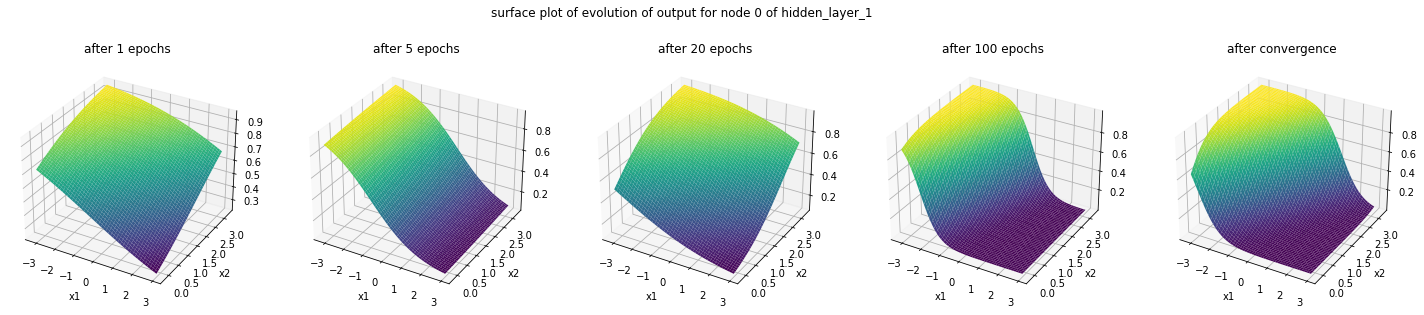

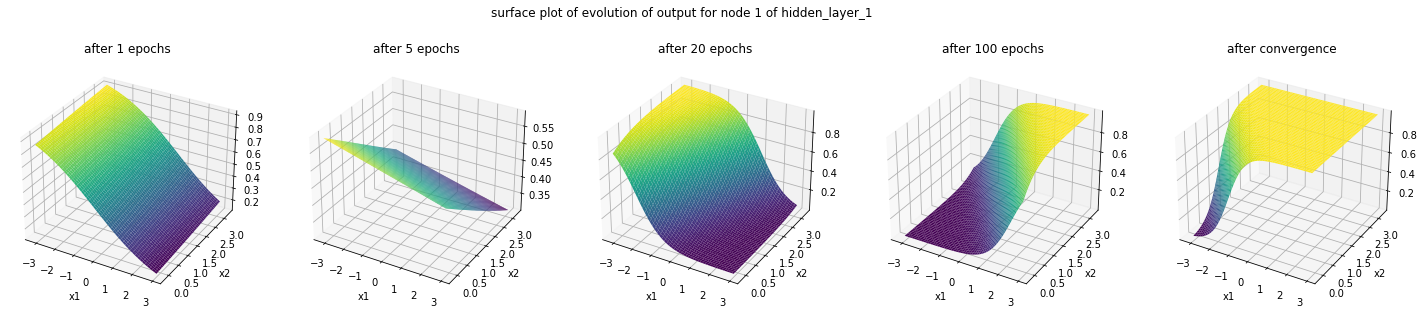

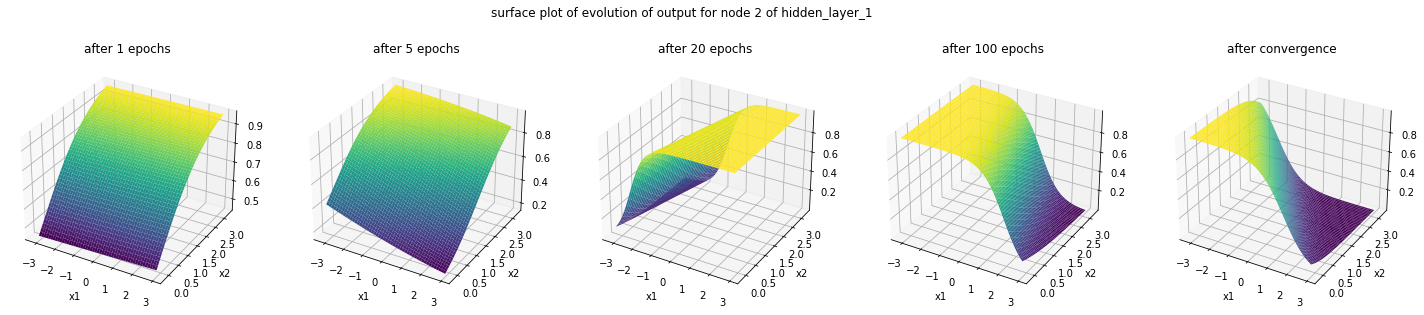

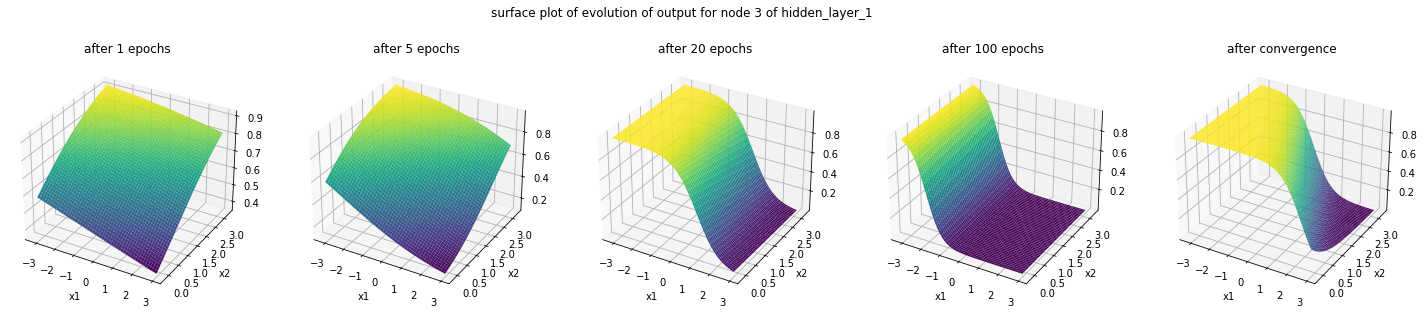

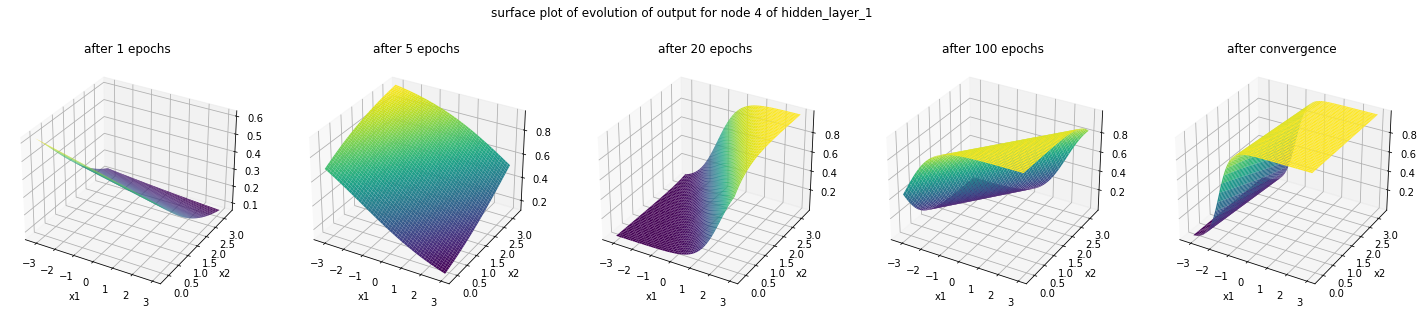

*******************************************


The evolution of outputs of 2nd hidden layer:


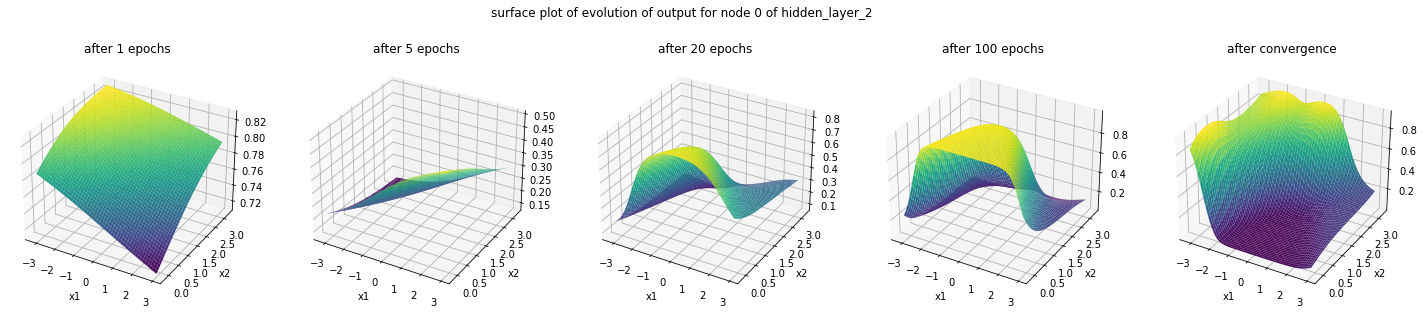

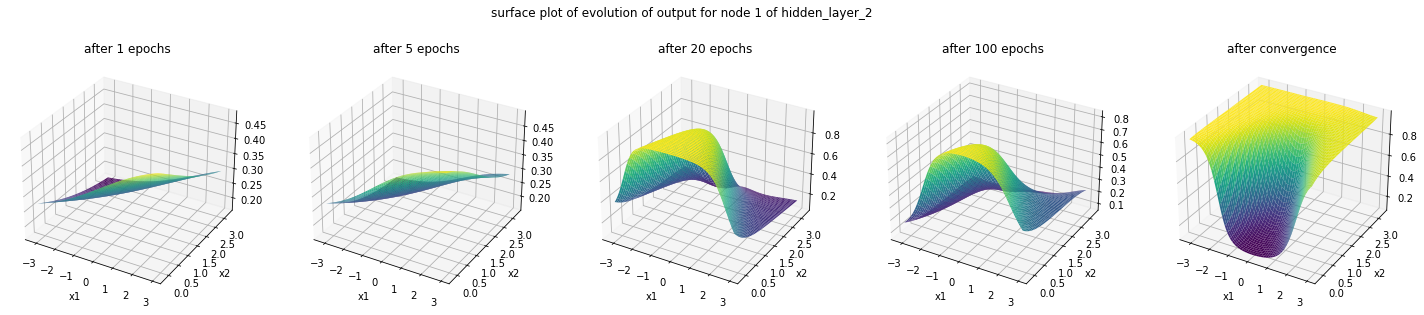

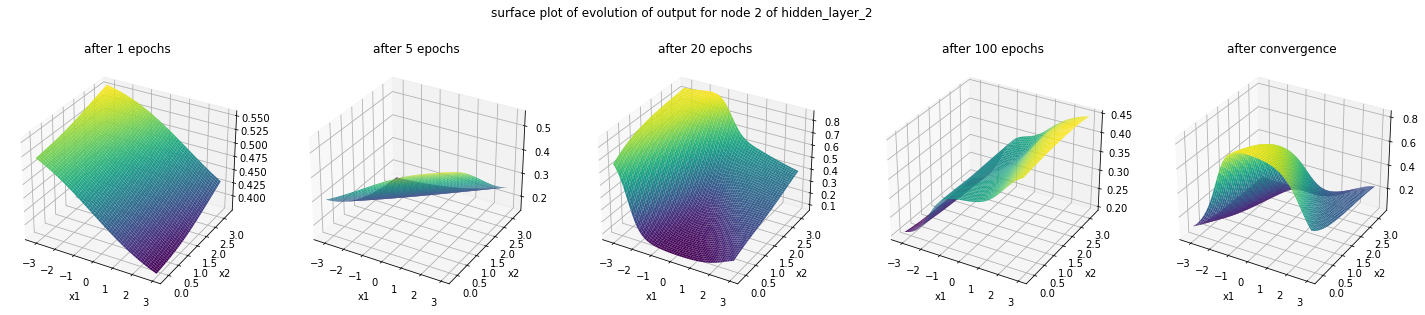

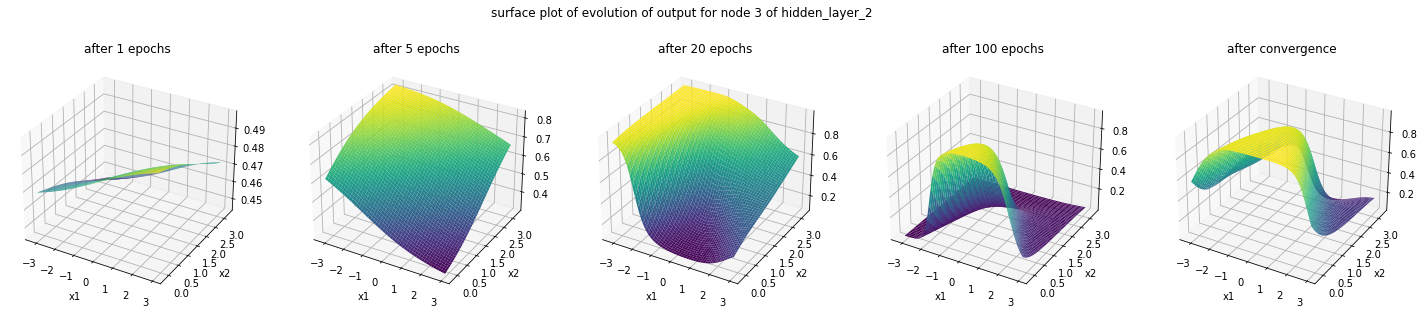

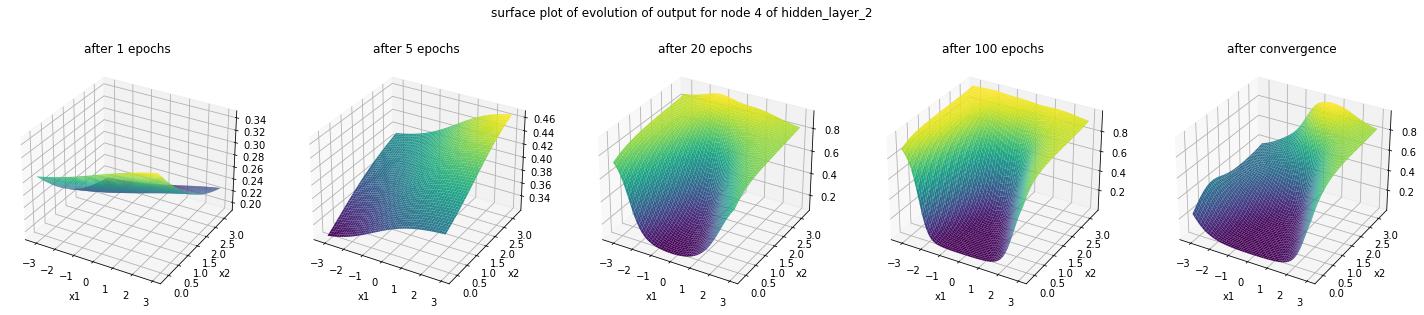

*******************************************


The evolution of outputs of output layer:


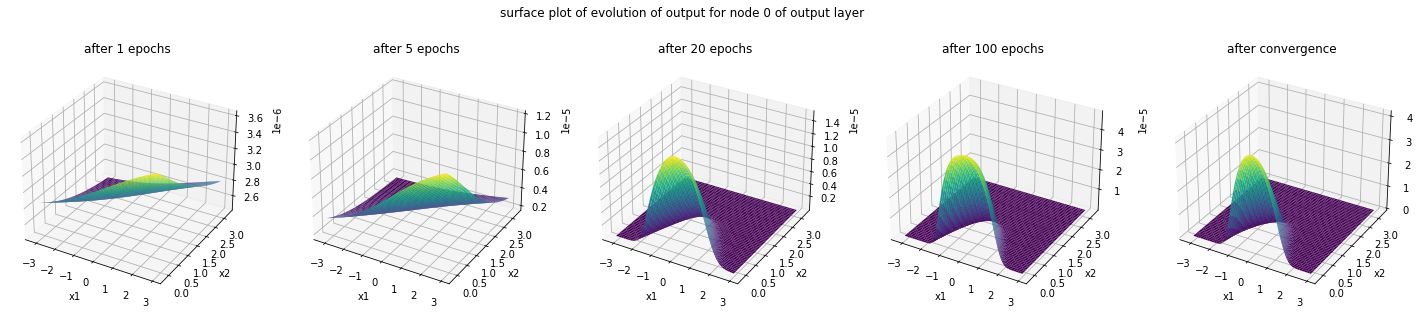

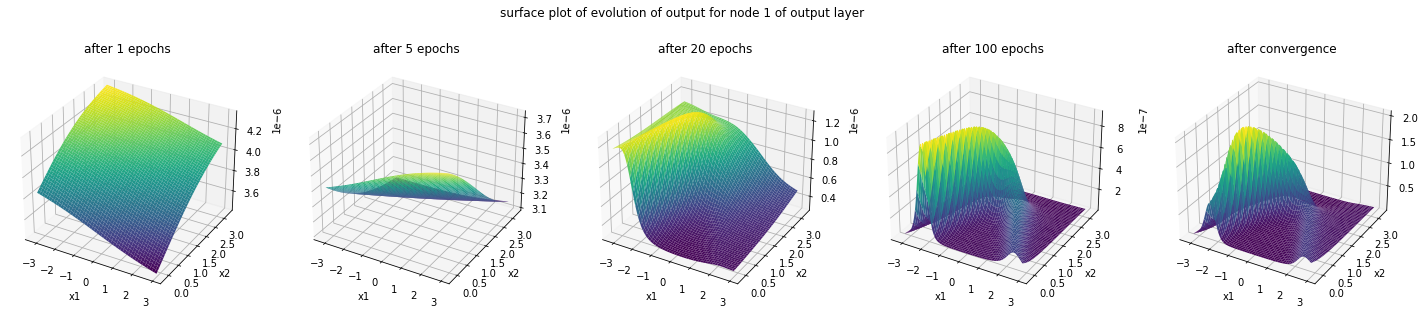

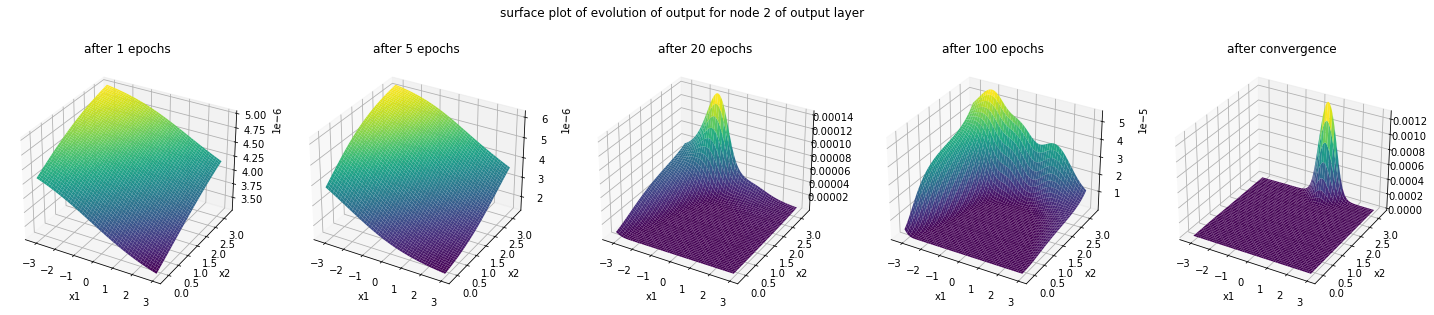

In [32]:
# plotting the evolution of outputs of nodes
print('The evolution of outputs of 1st hidden layer:')
num = hidden_1[0].shape[1]
for i in range(num):
    fig = plt.figure(figsize=(25,5))
    plt.suptitle(f'surface plot of evolution of output for node {i} of hidden_layer_1')
    ax = {}
    for j in range(len(hidden_1)):
#         plt.subplot(1,5,j+1)
#         ax = plt.axes(projection='3d')
        plot_no = 150 + j+1
        ax[j] = fig.add_subplot(plot_no, projection='3d')
        ax[j].plot_surface(XX, YY, hidden_1[j][:,i].reshape(XX.shape),cmap='viridis', edgecolor='none')
        if j != (len(hidden_1)-1):
            ax[j].set_title(f'after {epochs_[j]} epochs')
        else :
            ax[j].set_title('after convergence')
        plt.xlabel('x1')
        plt.ylabel('x2')
    plt.show()
print("*******************************************\n\n")
print('The evolution of outputs of 2nd hidden layer:')
num = hidden_2[0].shape[1]
for i in range(num):
    fig = plt.figure(figsize=(25,5))
    plt.suptitle(f'surface plot of evolution of output for node {i} of hidden_layer_2')
    ax = {}
    for j in range(len(hidden_2)):
#         plt.subplot(1,5,j+1)
#         ax = plt.axes(projection='3d')
        plot_no = 150 + j+1
        ax[j] = fig.add_subplot(plot_no, projection='3d')
        ax[j].plot_surface(XX, YY, hidden_2[j][:,i].reshape(XX.shape),cmap='viridis', edgecolor='none')
        if j != (len(hidden_1)-1):
            ax[j].set_title(f'after {epochs_[j]} epochs')
        else :
            ax[j].set_title('after convergence')
        plt.xlabel('x1')
        plt.ylabel('x2')
    plt.show()
print("*******************************************\n\n")
print('The evolution of outputs of output layer:')
num = output[0].shape[1]
for i in range(num):
    fig = plt.figure(figsize=(25,5))
    plt.suptitle(f'surface plot of evolution of output for node {i} of output layer')
    ax = {}
    for j in range(len(output)):
#         plt.subplot(1,5,j+1)
#         ax = plt.axes(projection='3d')
        plot_no = 150 + j+1
        ax[j] = fig.add_subplot(plot_no, projection='3d')
        ax[j].plot_surface(XX, YY, output[j][:,i].reshape(XX.shape),cmap='viridis', edgecolor='none')
        if j != (len(output)-1):
            ax[j].set_title(f'after {epochs_[j]} epochs')
        else :
            ax[j].set_title('after convergence')
        plt.xlabel('x1')
        plt.ylabel('x2')
    plt.show()

## Non-Linear SVM

In [33]:
# checking the hyperparameter - degree
classes = [0,1,2]
degrees = [1,2,3,4,5,6,7,8,9] ; c = 1000
accs = [] # store tuples of (h_neurons,tr_acc,tr_loss,va_acc,va_loss)
for degree in degrees:
    #creating a ovr classifier
    print(degree,end=' ')
    classifier = SVC(kernel = 'poly' , degree = degree , C = c) 
    non_linear_ovr = OneVsRestClassifier(classifier)
    non_linear_ovr.fit(x_train,y_train)

    yhat_va = non_linear_ovr.predict(x_va)
    yhat_tr = non_linear_ovr.predict(x_train)
    
    tr_acc  = accuracy_score(y_train,yhat_tr)
    va_acc  = accuracy_score(y_va,yhat_va)
    accs.append((degree,round(tr_acc,3),round(va_acc,3)))

print('degree, training accuracy, validation accuracy:')
for i in range(len(degrees)):
    print(accs[i]) 

1 2 3 4 5 6 7 8 9 degree, training accuracy, validation accuracy:
(1, 0.632, 0.667)
(2, 0.997, 0.978)
(3, 0.97, 0.978)
(4, 0.992, 0.911)
(5, 0.993, 0.978)
(6, 0.988, 0.911)
(7, 0.988, 0.933)
(8, 0.993, 0.911)
(9, 0.99, 0.911)


In [34]:
# checking the hyperparameter - c
classes = [0,1,2]
cs= [1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3] ; degree = 2
accs = [] # store tuples of (h_neurons,tr_acc,tr_loss,va_acc,va_loss)
for c in cs:
    #creating a ovr classifier
    print(c,end=' ')
    classifier = SVC(kernel = 'poly' , degree = degree , C = c) 
    non_linear_ovr = OneVsRestClassifier(classifier)
    non_linear_ovr.fit(x_train,y_train)

    yhat_va = non_linear_ovr.predict(x_va)
    yhat_tr = non_linear_ovr.predict(x_train)
    
    tr_acc  = accuracy_score(y_train,yhat_tr)
    va_acc  = accuracy_score(y_va,yhat_va)
    accs.append((c,round(tr_acc,3),round(va_acc,3)))

print('C, training accuracy, validation accuracy:')
for i in range(len(cs)):
    print(accs[i]) 

0.0001 0.001 0.01 0.1 1 10.0 100.0 1000.0 C, training accuracy, validation accuracy:
(0.0001, 0.667, 0.711)
(0.001, 0.667, 0.711)
(0.01, 0.667, 0.711)
(0.1, 0.75, 0.778)
(1, 0.955, 0.889)
(10.0, 0.992, 0.911)
(100.0, 0.997, 0.978)
(1000.0, 0.997, 0.978)


In [35]:
# classfication accuracy of best model on test data
degree , c = 2 , 100
classifier = SVC(kernel = 'poly' , degree = degree , C = c) 
non_linear_ovr = OneVsRestClassifier(classifier)
non_linear_ovr.fit(x_train,y_train)

yhat_te= non_linear_ovr.predict(x_test)
acc_te = accuracy_score(y_test,yhat_te)
print(f'Test data accuracy of best model is {acc_te*100}%')

Test data accuracy of best model is 100.0%


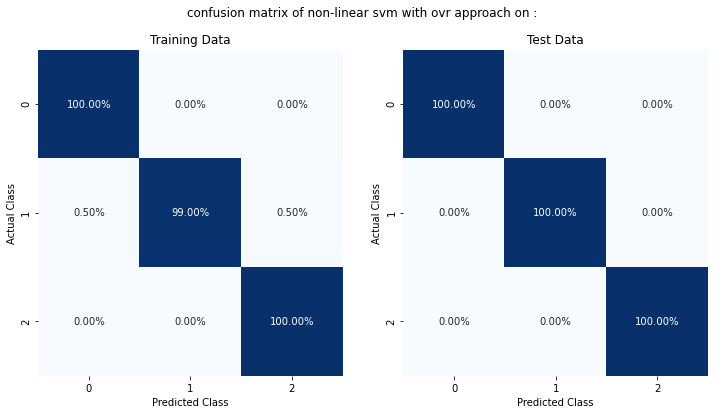

In [36]:
# confusion matrix for best model on training and test data
degree , c = 2 , 100
classifier = SVC(kernel = 'poly' , degree = degree , C = c) 
non_linear_ovr = OneVsRestClassifier(classifier)
non_linear_ovr.fit(x_train,y_train)

yhat_te= non_linear_ovr.predict(x_test)
yhat_tr = non_linear_ovr.predict(x_train)

fig = plt.figure(figsize=(12,6))
plt.suptitle(f'confusion matrix of non-linear svm with ovr approach on :')
for i in range(2):
    plt.subplot(1,2,i+1)
    cf = confusion_matrix(y_train,yhat_tr,normalize='true') if i==0 else confusion_matrix(y_test,yhat_te,normalize='true')
    sns.heatmap(cf,annot=True,fmt='.2%',cmap='Blues',cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Training Data' if i==0 else 'Test Data') 
plt.show()

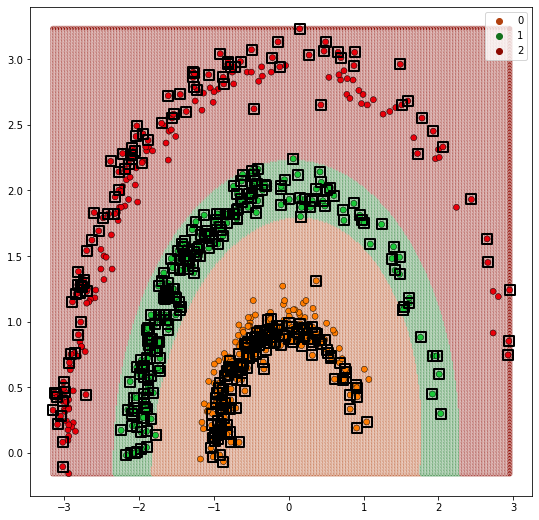

In [37]:
# plot of decision regions and support vectors
palette_light = cmap_light[:3]
palette_bold = cmap_bold[:3]

fig = plt.figure(figsize=(9,9))
ax = plt.gca()
xlim =  [np.amin(x_train[:,0]),np.amax(x_train[:,0])]
ylim = [np.amin(x_train[:,1]),np.amax(x_train[:,1])]
# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 300)
yy = np.linspace(ylim[0], ylim[1], 300)
YY, XX = np.meshgrid(yy, xx)
xy = np.c_[XX.ravel(), YY.ravel()]
Z = non_linear_ovr.predict(xy)
n = np.unique(Z).shape[0]
sns.scatterplot(x = XX.ravel(),y = YY.ravel(), hue = Z,palette=palette_light[:n],legend= True)
sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train.reshape((y_train.shape[0],)),palette=palette_bold,
                alpha=1.0,edgecolor="black",legend=False)
markers = ['^','v','>','<','*','+']
# for i in range(len(classes)):
#     plt.scatter(non_linear_ovr.estimators_[i].support_vectors_[:, 0], non_linear_ovr.estimators_[i].support_vectors_[:, 1]
#               ,marker=markers[i],color='k',linewidth=2,label=f'support vectors of class{classes[i]}')
for i in range(len(classes)):
    plt.scatter(non_linear_ovr.estimators_[i].support_vectors_[:, 0], non_linear_ovr.estimators_[i].support_vectors_[:, 1]
              ,marker='s',color='k',s=100,facecolors='none',linewidth=2)
plt.legend()
plt.show()

## Gaussian SVM

In [38]:
# checking the hyperparameter - gamma
classes = [0,1,2]
gammas = [1e-4,1e-3,1e-2,1e-1,1,1e1] ; c = 100
accs = [] # store tuples of (h_neurons,tr_acc,tr_loss,va_acc,va_loss)
for gamma in gammas:
    #creating a ovr classifier
    print(gamma,end=' ')
    classifier = SVC(kernel = 'rbf', gamma=gamma, C = c) 
    gaussian_ovr = OneVsRestClassifier(classifier)
    gaussian_ovr.fit(x_train,y_train)

    yhat_va = gaussian_ovr.predict(x_va)
    yhat_tr = gaussian_ovr.predict(x_train)
    
    tr_acc  = accuracy_score(y_train,yhat_tr)
    va_acc  = accuracy_score(y_va,yhat_va)
    accs.append((gamma,round(tr_acc,3),round(va_acc,3)))

print('gamma, training accuracy, validation accuracy:')
for i in range(len(gammas)):
    print(accs[i]) 

0.0001 0.001 0.01 0.1 1 10.0 gamma, training accuracy, validation accuracy:
(0.0001, 0.623, 0.689)
(0.001, 0.648, 0.711)
(0.01, 0.967, 0.978)
(0.1, 1.0, 1.0)
(1, 1.0, 1.0)
(10.0, 1.0, 1.0)


In [39]:
# checking the hyperparameter - c
classes = [0,1,2]
cs= [1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3] ; gammma = 1
accs = [] # store tuples of (h_neurons,tr_acc,tr_loss,va_acc,va_loss)
for c in cs:
    #creating a ovr classifier
    print(c,end=' ')
    classifier = SVC(kernel = 'rbf', gamma=gamma, C = c) 
    gaussian_ovr = OneVsRestClassifier(classifier)
    gaussian_ovr.fit(x_train,y_train)

    yhat_va = gaussian_ovr.predict(x_va)
    yhat_tr = gaussian_ovr.predict(x_train)
    
    tr_acc  = accuracy_score(y_train,yhat_tr)
    va_acc  = accuracy_score(y_va,yhat_va)
    accs.append((c,round(tr_acc,3),round(va_acc,3)))

print('C, training accuracy, validation accuracy:')
for i in range(len(cs)):
    print(accs[i]) 

0.0001 0.001 0.01 0.1 1 10.0 100.0 1000.0 C, training accuracy, validation accuracy:
(0.0001, 1.0, 1.0)
(0.001, 1.0, 1.0)
(0.01, 1.0, 1.0)
(0.1, 1.0, 1.0)
(1, 1.0, 1.0)
(10.0, 1.0, 1.0)
(100.0, 1.0, 1.0)
(1000.0, 1.0, 1.0)


From the outputs of above two cells we see that optimal value of gamma is 0.1 and c is 100 (for no outliers)

In [40]:
# classfication accuracy of best model on test data
gamma , c = 0.1 , 100
classifier = SVC(kernel = 'rbf' , gamma = gamma , C = c) 
gaussian_ovr = OneVsRestClassifier(classifier)
gaussian_ovr.fit(x_train,y_train)

yhat_te= gaussian_ovr.predict(x_test)
acc_te = accuracy_score(y_test,yhat_te)
print(f'Test data accuracy of best model is {acc_te*100}%')

Test data accuracy of best model is 100.0%


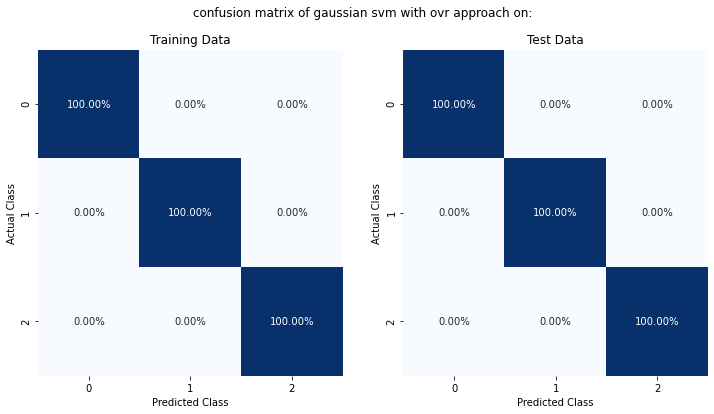

In [41]:
# confusion matrix for best model on training and test data
gamma , c = 0.1 , 100
classifier = SVC(kernel = 'rbf' , gamma = gamma , C = c) 
gaussian_ovr = OneVsRestClassifier(classifier)
gaussian_ovr.fit(x_train,y_train)

yhat_te= gaussian_ovr.predict(x_test)
yhat_tr = gaussian_ovr.predict(x_train)

fig = plt.figure(figsize=(12,6))
plt.suptitle(f'confusion matrix of gaussian svm with ovr approach on:')
for i in range(2):
    plt.subplot(1,2,i+1)
    cf = confusion_matrix(y_train,yhat_tr,normalize='true') if i==0 else confusion_matrix(y_test,yhat_te,normalize='true')
    sns.heatmap(cf,annot=True,fmt='.2%',cmap='Blues',cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Training Data' if i==0 else 'Test Data') 
plt.show()

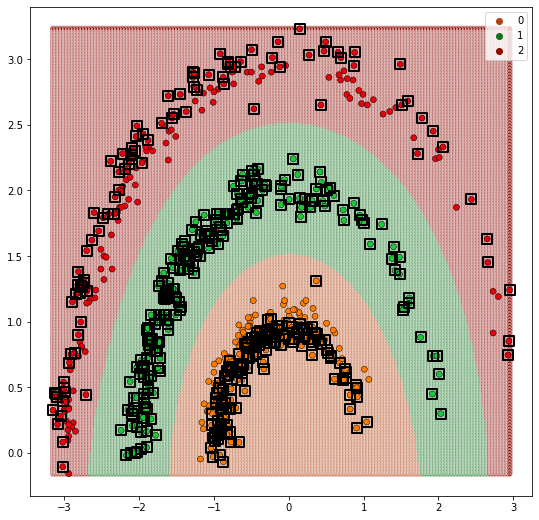

In [42]:
# plot of decision regions and support vectors
palette_light = cmap_light[:3]
palette_bold = cmap_bold[:3]

fig = plt.figure(figsize=(9,9))
ax = plt.gca()
xlim =  [np.amin(x_train[:,0]),np.amax(x_train[:,0])]
ylim = [np.amin(x_train[:,1]),np.amax(x_train[:,1])]
# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 300)
yy = np.linspace(ylim[0], ylim[1], 300)
YY, XX = np.meshgrid(yy, xx)
xy = np.c_[XX.ravel(), YY.ravel()]
Z = gaussian_ovr.predict(xy)
n = np.unique(Z).shape[0]
sns.scatterplot(x = XX.ravel(),y = YY.ravel(), hue = Z,palette=palette_light[:n],legend= True)
sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train.reshape((y_train.shape[0],)),palette=palette_bold,
                alpha=1.0,edgecolor="black",legend=False)
markers = ['^','v','>','<','*','+']
# for i in range(len(classes)):
#     plt.scatter(non_linear_ovr.estimators_[i].support_vectors_[:, 0], non_linear_ovr.estimators_[i].support_vectors_[:, 1]
#               ,marker=markers[i],color='k',linewidth=2,label=f'support vectors of class{classes[i]}')
for i in range(len(classes)):
    plt.scatter(non_linear_ovr.estimators_[i].support_vectors_[:, 0], non_linear_ovr.estimators_[i].support_vectors_[:, 1]
              ,marker='s',color='k',s=100,facecolors='none',linewidth=2)
plt.legend()
plt.show()

# Dataset 2A

In [43]:
classes = ['highway', 'insidecity', 'mountain', 'opencountry', 'tallbuilding']
class_to_ind = {}
for i,c in enumerate(classes):
    class_to_ind[c] = i
class_to_ind

for (i,c) in enumerate(classes):
    print(i,c,sep=' ')


0 highway
1 insidecity
2 mountain
3 opencountry
4 tallbuilding


In [44]:
# Loading Dataset 2A
y_train = []
x_train = None

x_class_tr = {} ; y_class_tr = {}  # dict for storing the training points of each class separately
x_class_va = {} ; y_class_va = {} # dict for storing the validations points of each class separately
x_class_te = {} ; y_class_te = {}  # dict for storing the test points of each class separately
len_tr, len_te , len_va = {},{},{}

print('Training Set : ')
for (i,c) in enumerate(classes):
    print(c)
    fil = 'G:\\ubuntu2-windows2\\Sem6\\PRML - CS5691\\Assignments_2021\\Assignment2/Dataset_2A/'+c+'/train.csv'
    df = pd.read_csv(fil)
    x_class_tr[i] = np.array(df.iloc[:,range(1,25,1)])
    len_tr[i] = df.shape[0] 
    if(x_train is None):
        x_train = np.array(df.iloc[:,range(1,25,1)])
    else:
        x_train = np.r_[x_train, np.array(df.iloc[:,range(1,25,1)])]
    y_train = y_train + [class_to_ind[c]]*df.shape[0]
    print(' ',c, df.shape[0])
y_train = np.array(y_train)

y_test = []
y_va = []
x_va = None
x_test = None
print('Dev Set : ')
for (i,c) in enumerate(classes):
    fil = 'G:\\ubuntu2-windows2\\Sem6\\PRML - CS5691\\Assignments_2021\\Assignment2/Dataset_2A/'+c+'/dev.csv'
    df = pd.read_csv(fil)
    nc = df.shape[0]
    x_class_va[i] = np.array(df.iloc[:int(0.6*nc),range(1,25,1)])
    x_class_te[i] = np.array(df.iloc[int(0.6*nc):,range(1,25,1)])
    len_va[i] = int(0.6*nc)
    len_te[i] = nc-int(0.6*nc)
    if(x_test is None):
        x_test = np.array(df.iloc[int(0.6*nc):,range(1,25,1)])
        x_va = np.array(df.iloc[:int(0.6*nc),range(1,25,1)])
    else:
        x_test = np.r_[x_test, np.array(df.iloc[int(0.6*nc):,range(1,25,1)])]
        x_va = np.r_[x_va, np.array(df.iloc[:int(0.6*nc),range(1,25,1)])]
    y_va = y_va + [class_to_ind[c]]*int(0.6*nc)
    y_test = y_test + [class_to_ind[c]]*(nc - int(0.6*nc))
    print(' ',c, df.shape[0])
y_test = np.array(y_test)
y_va = np.array(y_va)
y_va.shape

Training Set : 
highway
  highway 182
insidecity
  insidecity 215
mountain
  mountain 261
opencountry
  opencountry 287
tallbuilding
  tallbuilding 249
Dev Set : 
  highway 52
  insidecity 62
  mountain 75
  opencountry 82
  tallbuilding 71


(204,)

## MLFFNN

In [45]:
#utilities
def build_mlfnn(hidden_neurons,num_layers=1,num_classes=4): #hidden neurons is a list of number of hidden units in each hidden layer
    model=tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(24)))
    model.add(tf.keras.layers.Dense(hidden_neurons[0],activation='relu'))
    if num_layers==2:
        model.add(tf .keras.layers.Dense(hidden_neurons[1],activation='relu'))

    model.add(tf.keras.layers.Dense(num_classes,activation='softmax'))
    return model

def train_model(model,epochs,X_train,Y_train,X_valid,Y_valid,verbose = 0):
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,optimizer=keras.optimizers.SGD(lr=1),metrics=['accuracy'])
    history=model.fit(X_train,Y_train,epochs=epochs,batch_size=32,validation_data=(X_valid,Y_valid),verbose=verbose)
    return history

In [46]:
# tables of classification accuracy for different values of hyperparameters
seed(0) 
set_seed(0)

epochs = 200
model_metrics = {}

list_h_neurons = [[20,20,20],[12,12],[13,13],[14,14],[15,15],[16,16],[17,17],[18,18],[20,20],[22,22],[24,24],[26,26],[24],[25],[26],[27],[28],[29],[30],[31],[32],[35],[36],[40],[44],[48],[52]]
for (count,h_neurons) in enumerate(list_h_neurons):
    model = build_mlfnn(hidden_neurons=h_neurons,num_layers=len(h_neurons),num_classes=5)
    train_model(model,epochs,x_train,y_train,x_va,y_va)
    print('\n *************************************************** \n')
    y_tr_predict = model.predict(x_train) ; y_tr_predict = np.argmax(y_tr_predict,axis=1)
    y_va_predict = model.predict(x_va)    ; y_va_predict = np.argmax(y_va_predict,axis=1)
    # y_te_predict = model.predict(x_te)    ; y_te_predict = np.argmax(y_te_predict,axis=1) 
    
    tr_loss, tr_acc = model.evaluate(x_train,y_train,verbose=1)
    va_loss, va_acc = model.evaluate(x_va,y_va,verbose=1)
    model_metrics[count] = (h_neurons,round(tr_loss,3),round(tr_acc,3)*100,round(va_loss,3),round(va_acc,3)*100)
print('h_neurons' , 'training loss', 'training accuracy', 'validation loss' , 'validation accuracy')
for i in range(len(model_metrics)):
    print(model_metrics[i])


 *************************************************** 

7/7 [==============================] - 0s 859us/step - loss: 1.6084 - accuracy: 0.5343

 *************************************************** 

7/7 [==============================] - 0s 570us/step - loss: 1.4821 - accuracy: 0.4657

 *************************************************** 

7/7 [==============================] - 0s 814us/step - loss: 1.5144 - accuracy: 0.4853

 *************************************************** 

7/7 [==============================] - 0s 680us/step - loss: 1.6197 - accuracy: 0.4755

 *************************************************** 

7/7 [==============================] - 0s 911us/step - loss: 1.7517 - accuracy: 0.5196

 *************************************************** 

7/7 [==============================] - 0s 713us/step - loss: 1.4978 - accuracy: 0.5049

 *************************************************** 

7/7 [==============================] - 0s 575us/step - loss: 1.6250 - accuracy: 0.5098

In [47]:
# tables of classification accuracy for different values of hyperparameters
seed(0) 
set_seed(0)

epochs = 200
model_metrics = {}

list_h_neurons = [[20,20,20],[22,22,22],[24,24,24],[28,28,28],[60],[70],[80],[90]]
for (count,h_neurons) in enumerate(list_h_neurons):
    model = build_mlfnn(hidden_neurons=h_neurons,num_layers=len(h_neurons),num_classes=5)
    train_model(model,epochs,x_train,y_train,x_va,y_va)
    print('\n *************************************************** \n')
    y_tr_predict = model.predict(x_train) ; y_tr_predict = np.argmax(y_tr_predict,axis=1)
    y_va_predict = model.predict(x_va)    ; y_va_predict = np.argmax(y_va_predict,axis=1)
    # y_te_predict = model.predict(x_te)    ; y_te_predict = np.argmax(y_te_predict,axis=1) 
    
    tr_loss, tr_acc = model.evaluate(x_train,y_train,verbose=1)
    va_loss, va_acc = model.evaluate(x_va,y_va,verbose=1)
    model_metrics[count] = (h_neurons,round(tr_loss,3),round(tr_acc,3)*100,round(va_loss,3),round(va_acc,3)*100)
print('h_neurons' , 'training loss', 'training accuracy', 'validation loss' , 'validation accuracy')
for i in range(len(model_metrics)):
    print(model_metrics[i])


 *************************************************** 

7/7 [==============================] - 0s 666us/step - loss: 1.6084 - accuracy: 0.5343

 *************************************************** 

7/7 [==============================] - 0s 716us/step - loss: 1.9243 - accuracy: 0.5000

 *************************************************** 

7/7 [==============================] - 0s 712us/step - loss: 1.6914 - accuracy: 0.5245

 *************************************************** 

7/7 [==============================] - 0s 855us/step - loss: 1.6238 - accuracy: 0.5049

 *************************************************** 

7/7 [==============================] - 0s 713us/step - loss: 2.2862 - accuracy: 0.4951

 *************************************************** 

7/7 [==============================] - 0s 712us/step - loss: 2.8286 - accuracy: 0.4804

 *************************************************** 

7/7 [==============================] - 0s 669us/step - loss: 2.4590 - accuracy: 0.5343

The best model according to the above two cells is the one with single hidden layer and 48 neurons

In [48]:
# classification accuracy of best model on test data
seed(0)
set_seed(0)
epochs = 200
best_h_neurons = [48]
model = build_mlfnn(hidden_neurons=best_h_neurons,num_layers=len(best_h_neurons),num_classes=5)
train_model(model,epochs,x_train,y_train,x_va,y_va)

te_loss,te_acc = model.evaluate(x_test,y_test)
print(round(te_loss,3),te_acc*100)

5/5 [==============================] - 0s 0s/step - loss: 1.8413 - accuracy: 0.5217
1.841 52.173912525177


7/7 [==============================] - 0s 0s/step - loss: 2.3208 - accuracy: 0.5098


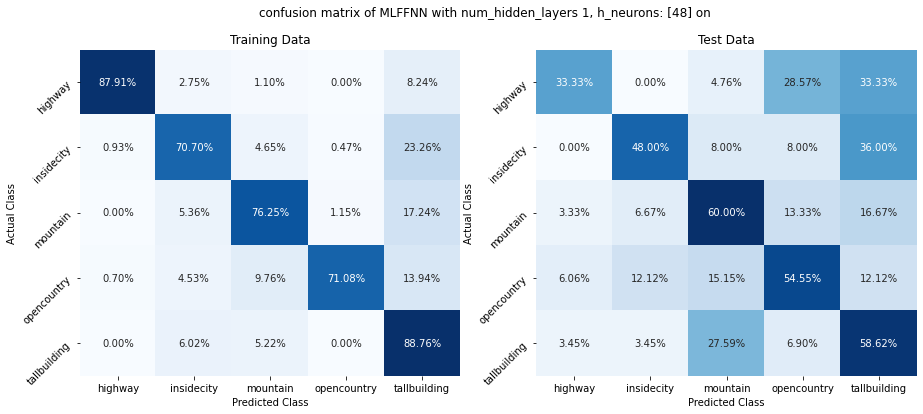

In [55]:
#confusion matrix for best model on Training and Test Data
seed(0)
set_seed(0)
best_h_neurons = [48]
epochs = 200
model = build_mlfnn(hidden_neurons=best_h_neurons,num_layers=len(best_h_neurons),num_classes=5)
train_model(model,epochs,x_train,y_train,x_va,y_va)

yhat_tr = model.predict(x_train) ; yhat_tr = np.argmax(yhat_tr,axis=1)
yhat_te = model.predict(x_test)  ; yhat_te = np.argmax(yhat_te,axis=1)
model.evaluate(x_train,y_train) ; model.evaluate(x_va,y_va)

fig = plt.figure(figsize=(15,6))
plt.suptitle(f'confusion matrix of MLFFNN with num_hidden_layers {len(best_h_neurons)}, h_neurons: {best_h_neurons} on')
for i in range(2):
    plt.subplot(1,2,i+1)
    cf = confusion_matrix(y_train,yhat_tr,normalize='true')if i==0 else confusion_matrix(y_test,yhat_te,normalize='true')
    sns.heatmap(cf,annot=True,fmt='.2%',cmap='Blues',cbar=False,xticklabels=classes, yticklabels=classes)
    plt.yticks(rotation=45)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Training Data' if i==0 else 'Test Data') 
plt.show()

## Gaussian SVM

In [50]:
# checking the hyperparameter - gamma
classes = ['highway', 'insidecity', 'mountain', 'opencountry', 'tallbuilding']
gammas = [1e-4,1e-3,1e-2,1e-1,1,1e1] ; c = 100
accs = [] # store tuples of (h_neurons,tr_acc,tr_loss,va_acc,va_loss)
for gamma in gammas:
    #creating a ovr classifier
    print(gamma,end=' ')
    classifier = SVC(kernel = 'rbf', gamma=gamma, C = c) 
    gaussian_ovr = OneVsRestClassifier(classifier)
    gaussian_ovr.fit(x_train,y_train)

    yhat_va = gaussian_ovr.predict(x_va)
    yhat_tr = gaussian_ovr.predict(x_train)
    
    tr_acc  = accuracy_score(y_train,yhat_tr)
    va_acc  = accuracy_score(y_va,yhat_va)
    accs.append((gamma,round(tr_acc,3),round(va_acc,3)))

print('gamma, training accuracy, validation accuracy:')
for i in range(len(gammas)):
    print(accs[i]) 

0.0001 0.001 0.01 0.1 1 10.0 gamma, training accuracy, validation accuracy:
(0.0001, 0.507, 0.392)
(0.001, 0.506, 0.397)
(0.01, 0.563, 0.475)
(0.1, 0.668, 0.529)
(1, 0.885, 0.539)
(10.0, 1.0, 0.515)


In [51]:
# checking the hyperparameter - c
classes = ['highway', 'insidecity', 'mountain', 'opencountry', 'tallbuilding']
cs= [1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3] ; gammma = 1
accs = [] # store tuples of (h_neurons,tr_acc,tr_loss,va_acc,va_loss)
for c in cs:
    #creating a ovr classifier
    print(c,end=' ')
    classifier = SVC(kernel = 'rbf', gamma=gamma, C = c) 
    gaussian_ovr = OneVsRestClassifier(classifier)
    gaussian_ovr.fit(x_train,y_train)

    yhat_va = gaussian_ovr.predict(x_va)
    yhat_tr = gaussian_ovr.predict(x_train)
    
    tr_acc  = accuracy_score(y_train,yhat_tr)
    va_acc  = accuracy_score(y_va,yhat_va)
    accs.append((c,round(tr_acc,3),round(va_acc,3)))

print('C, training accuracy, validation accuracy:')
for i in range(len(cs)):
    print(accs[i]) 

0.0001 0.001 0.01 0.1 1 10.0 100.0 1000.0 C, training accuracy, validation accuracy:
(0.0001, 0.794, 0.539)
(0.001, 0.848, 0.554)
(0.01, 0.857, 0.534)
(0.1, 0.86, 0.534)
(1, 0.925, 0.534)
(10.0, 0.997, 0.525)
(100.0, 1.0, 0.515)
(1000.0, 1.0, 0.515)


From the above two cells we decide to take gamma = 1 and c = 0.001

In [52]:
# classfication accuracy of best model on test data
gamma , c = 1 , 0.001
classifier = SVC(kernel = 'rbf' , gamma = gamma , C = c) 
gaussian_ovr = OneVsRestClassifier(classifier)
gaussian_ovr.fit(x_train,y_train)

yhat_te= gaussian_ovr.predict(x_test)
acc_te = accuracy_score(y_test,yhat_te)
print(f'Test data accuracy of best model is {acc_te*100}%')

Test data accuracy of best model is 49.275362318840585%


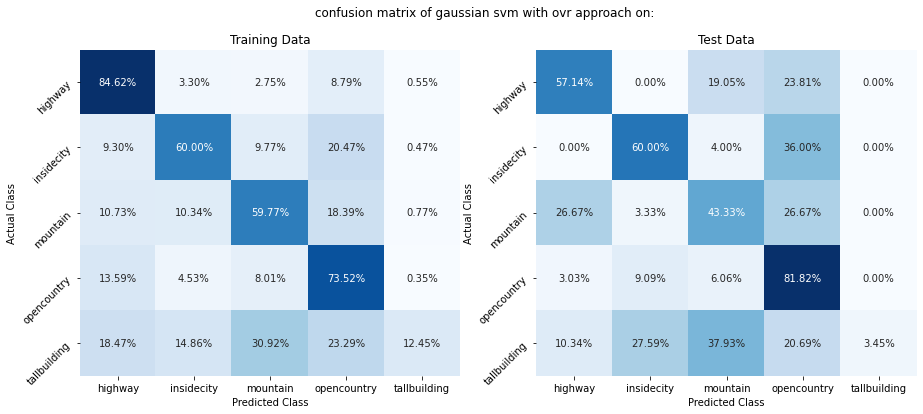

In [53]:
# confusion matrix for best model on training and test data
gamma , c = 1 , 0.001
classifier = SVC(kernel = 'rbf' , gamma = gamma , C = c) 
gaussian_ovr = OneVsRestClassifier(classifier)
gaussian_ovr.fit(x_train,y_train)

yhat_te= gaussian_ovr.predict(x_test)
yhat_tr = gaussian_ovr.predict(x_train)

fig = plt.figure(figsize=(15,6))
plt.suptitle(f'confusion matrix of gaussian svm with ovr approach on:')
for i in range(2):
    plt.subplot(1,2,i+1)
    cf = confusion_matrix(y_train,yhat_tr,normalize='true') if i==0 else confusion_matrix(y_test,yhat_te,normalize='true')
    sns.heatmap(cf,annot=True,fmt='.2%',cmap='Blues',cbar=False,xticklabels=classes, yticklabels=classes)
    plt.yticks(rotation=45)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Training Data' if i==0 else 'Test Data') 
plt.show()